In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_all = pd.read_excel("sleep75.xls")
df_all.head()

,age,black,case,clerical,construction,education,earnings,good_health,labor_force,leisure_1,...,spouse_work,total_work,union,work_main,work_scnd,expertise,young_kid,years_married,hour_wage,age_squared
0,32,0,1,0.0,0.0,12,0,0,1,3529,...,0,3438,0,3438,0,14,0,13,7.070004,1024
1,31,0,2,0.0,0.0,14,9500,1,1,2140,...,0,5020,0,5020,0,11,0,0,1.429999,961
2,44,0,3,0.0,0.0,17,42500,1,1,4595,...,1,2815,0,2815,0,21,0,0,20.53,1936
3,30,0,4,0.0,0.0,12,42500,1,1,3211,...,1,3786,0,3786,0,12,0,12,9.619998,900
4,64,0,5,0.0,0.0,14,2500,1,1,4052,...,1,2580,0,2580,0,44,0,33,2.75,4096


## Data Cleansing
> Type Casting

In [3]:
type_mapping = {
    'age': np.int64,
    'black': np.int64,
    'case': np.int64,
    'clerical': np.int64,
    'construction': np.int64,
    'education': np.int64,
    'earnings': np.int64,
    'good_health': np.int64,
    'labor_force': np.int64,
    'leisure_1': np.int64,
    'leisure_2': np.int64,
    'leisure_3': np.int64,
    'smsa': np.int64,
    'lhrwage': np.float64,
    'othinc': np.float64,
    'male': np.int64,
    'married': np.int64,
    'protestant': np.int64,
    'relax_all': np.int64,
    'self_employed': np.int64,
    'sleep': np.int64,
    'sleep_naps': np.int64,
    'south': np.int64,
    'spouse_pay': np.int64,
    'spouse_work': np.int64,
    'total_work': np.int64,
    'union': np.int64,
    'work_main': np.int64,
    'work_scnd': np.int64,
    'expertise': np.int64,
    'young_kid': np.int64,
    'years_married': np.int64,
    'hour_wage': np.float64,
    'age_squared': np.int64
}

In [4]:
assert not set(type_mapping.keys()).difference(set(df_all.columns)), "Not all columns are handled"

In [5]:
def can_cast(value: object, type_: type) -> bool:
    try:
        type_(value)
        if (issubclass(type_, int) or issubclass(type_, np.integer)) and not np.float64(value).is_integer():
            return False  # Prevent casting float-like strings to int
        return True
    except ValueError:
        return False

> converting invalid data in cells to NaNs

In [6]:
for column in df_all.columns:
    df_all[column] = df_all[column] \
    .apply(lambda x: x if can_cast(x, type_mapping[column]) else np.nan) \

df_all = df_all.astype({k: v.__name__.title() for k, v in type_mapping.items()})

In [7]:
df_all[["leisure_2", "leisure_3", "sleep_naps", "total_work", "sleep"]]

,leisure_2,leisure_3,sleep_naps,total_work,sleep
0,3479,3479,3163,3438,3113
1,2140,2140,2920,5020,2920
2,4505,4227,2760,2815,2670
3,3211,3211,3083,3786,3083
4,4007,4007,3493,2580,3448
...,...,...,...,...,...
701,4669,4644,3385,2026,2985
702,5870,5870,3535,675,3520
703,4719,4584,3510,1851,3510
704,5119,5031,3000,1961,2970


In [8]:
# columns = df_all.columns[:9].tolist() + df_all.columns[13:18].tolist() + [df_all.columns[21]] + df_all.columns[23:].tolist()
# print(columns)
df = df_all#[columns]

In [9]:
df.dtypes

age                Int64
black              Int64
case               Int64
clerical           Int64
construction       Int64
education          Int64
earnings           Int64
good_health        Int64
labor_force        Int64
leisure_1          Int64
leisure_2          Int64
leisure_3          Int64
smsa               Int64
lhrwage          Float64
othinc           Float64
male               Int64
married            Int64
protestant         Int64
relax_all          Int64
self_employed      Int64
sleep              Int64
sleep_naps         Int64
south              Int64
spouse_pay         Int64
spouse_work        Int64
total_work         Int64
union              Int64
work_main          Int64
work_scnd          Int64
expertise          Int64
young_kid          Int64
years_married      Int64
hour_wage        Float64
age_squared        Int64
dtype: object

### Missingness
About 25% percent of data in columns `['Construction', 'Clerical', 'lhrwage', 'hour_wage']` are missing

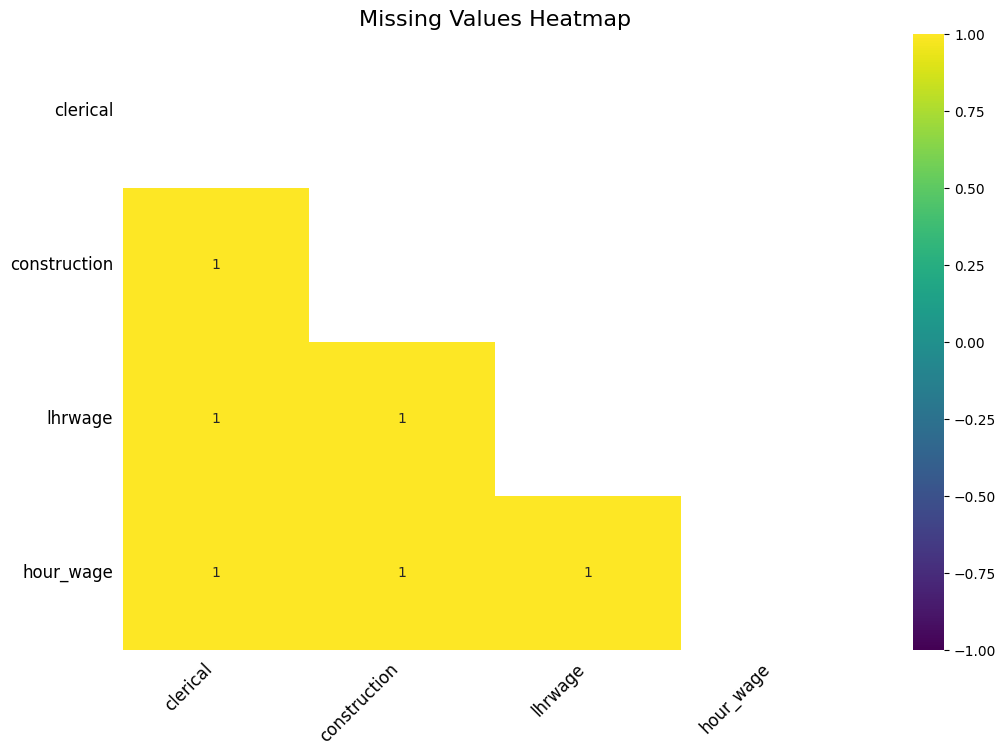

<Axes: >

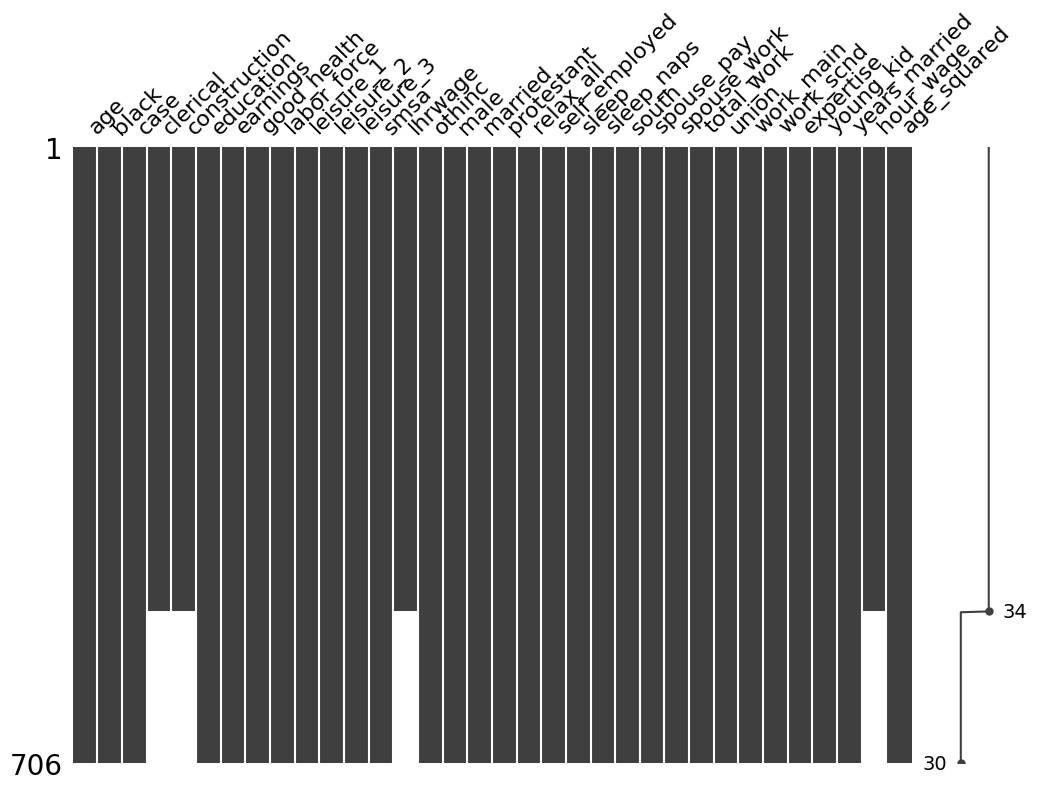

In [10]:
import missingno as msno

msno.heatmap(df, figsize=(12, 8), fontsize=12, cmap='viridis')
plt.title("Missing Values Heatmap", fontsize=16)
plt.show()

msno.matrix(df, figsize=(12, 8))

### Imputation
> Non-binary data is imputed based on 'educated' mean, mean of a group to which that person most likely belongs to
> Binary data is imputed by chance, base on how the data wos distributed before imputation

In [11]:
def impute_by_priority_mean(df: pd.DataFrame, target_col: str, group_priority: list[str]) -> pd.DataFrame:
    """Impute missing values in a target column using the mean of groups defined by a priority list of columns."""
    group_means = {}
    # Precompute means for all group levels
    for i in range(len(group_priority), 0, -1):
        group_cols = group_priority[:i]
        group_means[tuple(group_cols)] = (
            df.groupby(group_cols)[target_col].mean()
        )

    def impute(row):
        if pd.notna(row[target_col]):
            return row[target_col]
        # Try from most specific to least specific group
        for i in range(len(group_priority), 0, -1):
            group_cols = group_priority[:i]
            key = tuple(row[col] for col in group_cols)
            means = group_means[tuple(group_cols)]
            if key in means and pd.notna(means[key]):
                return means[key]
        return df[target_col].mean()

    df[target_col] = df.apply(impute, axis=1)
    return df

priority = ["black", "education", "good_health", "male", "married", "self_employed", "age"]

float64_cols = df.select_dtypes(include=['float64'])
columns_with_na = float64_cols.columns[float64_cols.isna().any()].tolist()
for col in columns_with_na:
    df = impute_by_priority_mean(df, col, priority)


random_columns = ["clerical", "construction"]

for col in random_columns:
    probs = df[col].value_counts(normalize=True)
    num_nans = df[col].isna().sum()
    fill_values = np.random.choice(probs.index, size=num_nans, p=probs.values)
    df.loc[df[col].isna(), col] = fill_values
df

,age,black,case,clerical,construction,education,earnings,good_health,labor_force,leisure_1,...,spouse_work,total_work,union,work_main,work_scnd,expertise,young_kid,years_married,hour_wage,age_squared
0,32,0,1,0,0,12,0,0,1,3529,...,0,3438,0,3438,0,14,0,13,7.070004,1024
1,31,0,2,0,0,14,9500,1,1,2140,...,0,5020,0,5020,0,11,0,0,1.429999,961
2,44,0,3,0,0,17,42500,1,1,4595,...,1,2815,0,2815,0,21,0,0,20.530000,1936
3,30,0,4,0,0,12,42500,1,1,3211,...,1,3786,0,3786,0,12,0,12,9.619998,900
4,64,0,5,0,0,14,2500,1,1,4052,...,1,2580,0,2580,0,44,0,33,2.750000,4096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,45,0,702,0,0,12,5500,1,0,5069,...,1,2026,0,2026,0,27,0,18,1.769999,2025
702,34,0,703,0,0,10,2500,0,0,5885,...,0,675,1,465,210,18,0,4,4.530001,1156
703,37,0,704,1,0,12,3500,1,0,4719,...,1,1851,0,1851,0,19,0,17,3.378104,1369
704,54,0,705,0,0,17,32500,1,0,5149,...,1,1961,1,1481,480,31,0,22,4.776000,2916


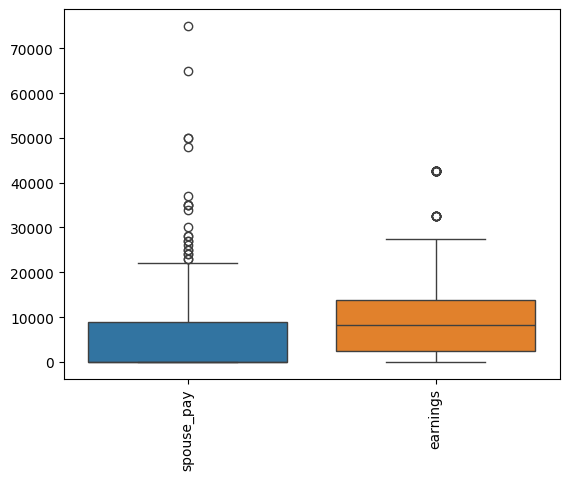

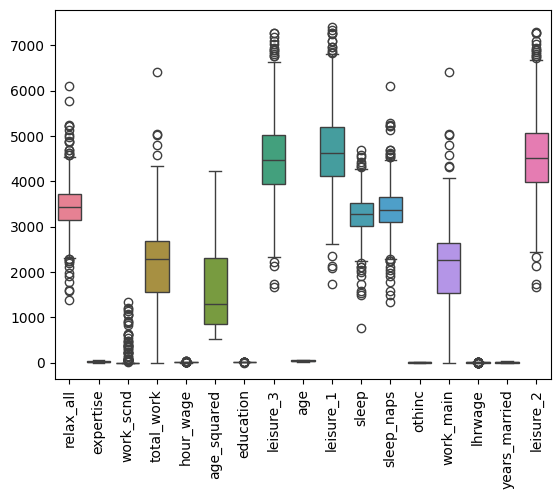

In [31]:
big_columns = {"earnings", "spouse_pay"}
binary_columns = set(df.columns[df.nunique() == 2])
low_columns = set(df.columns[df.max() <= 200]) - binary_columns

sns.boxplot(df[list(big_columns)])
plt.xticks(rotation=90)
plt.show()

sns.boxplot(df[list(set(df.columns) - big_columns - {"case"} - binary_columns - low_)])
plt.xticks(rotation=90)
plt.show()

In [29]:
set(df.columns[df.nunique() == 2])

{'black',
 'clerical',
 'construction',
 'good_health',
 'labor_force',
 'male',
 'married',
 'protestant',
 'self_employed',
 'smsa',
 'south',
 'spouse_work',
 'union',
 'young_kid'}